In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from decifer import (
    HDF5Dataset,
)

import matplotlib.pyplot as plt

class SimpleModel(nn.Module):
    def __init__(self, vocab_size, token_input_size, numeric_input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        
        # Tokenized data goes through embedding and a simple feedforward layer
        self.embedding = nn.Embedding(vocab_size, token_input_size)  # Adjust vocabulary size
        self.fc_token = nn.Linear(token_input_size, hidden_size)

        # Final layer to produce the output
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, token_data):
        # Tokenized data
        embedded = self.embedding(token_data)
        token_output = nn.functional.elu(self.fc_token(embedded.mean(dim=1)))  # Take mean across tokens

        # Final output
        return self.fc_out(token_output)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, debug_max=None):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        # Send data to device (GPU or CPU)
        token_data, numeric_data = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(token_data)
        loss = criterion(outputs, numeric_data)  # Using numeric data as the target for simplicity
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if debug_max is not None:
            if i > debug_max:
                break

    return running_loss / len(train_loader)


# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device, debug_max=None):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            token_data, numeric_data = batch[0].to(device), batch[1].to(device)

            outputs = model(token_data)
            loss = criterion(outputs, numeric_data)  # Using numeric data as the target for simplicity

            running_loss += loss.item()
            
            if debug_max is not None:
                if i > debug_max:
                    break

    return running_loss / len(val_loader)


def sample(model, val_loader, device):
    model.eval()
    with torch.no_grad():
       
        for i, batch in enumerate(val_loader):
            token_data, numeric_data = batch[0].to(device), batch[1].to(device)
            outputs = model(token_data)
            
            plt.figure()
            plt.plot(numeric_data[0].cpu().numpy(), label='Label')
            plt.plot(outputs[0].cpu().numpy(), label='gen')
            plt.legend()
            plt.show()
        
            if i > 5:
                break

# Simple training loop
def run_training(train_loader, val_loader, vocab_size, token_input_size, numeric_input_size, hidden_size, output_size, epochs=5, debug_max=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, loss function, and optimizer
    model = SimpleModel(vocab_size, token_input_size, numeric_input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device, debug_max)
        val_loss = evaluate_model(model, val_loader, criterion, device, debug_max)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model


In [84]:
# Example dataset loading (adjust paths as necessary)
block_size = 1000
train_dataset = HDF5Dataset('../data/chili100k/hdf5_data/train_dataset.h5', ['xrd_tokenized', 'xrd_cont_y'], block_size)
val_dataset = HDF5Dataset('../data/chili100k/hdf5_data/val_dataset.h5', ['xrd_tokenized', 'xrd_cont_y'], block_size)
test_dataset = HDF5Dataset('../data/chili100k/hdf5_data/test_dataset.h5', ['xrd_tokenized', 'xrd_cont_y'], block_size)

# Load metadata
import json

# Open and read the JSON file
with open('../data/chili100k/metadata.json', 'r') as file:
    data = json.load(file)

# Print the data
# print(data)

vocab_size = data['vocab_size']
numeric_input_size = data['xrd_parameters']['qgrid_len']  # Size of numeric input
output_size = data['xrd_parameters']['qgrid_len']  # Output size (same as input size for simplicity)

token_input_size = 1024  # Embedding size for tokenized input
hidden_size = 1024  # Size of hidden layers

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
debug_max = None
trained_model = run_training(train_loader, val_loader, vocab_size, token_input_size, 
                             numeric_input_size, hidden_size, output_size, epochs=5, debug_max=debug_max)

Epoch 1/5, Train Loss: 0.0167, Val Loss: 0.0141
Epoch 2/5, Train Loss: 0.0134, Val Loss: 0.0142
Epoch 3/5, Train Loss: 0.0136, Val Loss: 0.0134
Epoch 4/5, Train Loss: 0.0133, Val Loss: 0.0134
Epoch 5/5, Train Loss: 0.0134, Val Loss: 0.0137


In [86]:
# Evaluate on test set (for simplicity)
test_loss = evaluate_model(trained_model, test_loader, nn.MSELoss(), 
                           torch.device('cuda' if torch.cuda.is_available() else 'cpu'), debug_max=debug_max)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0142


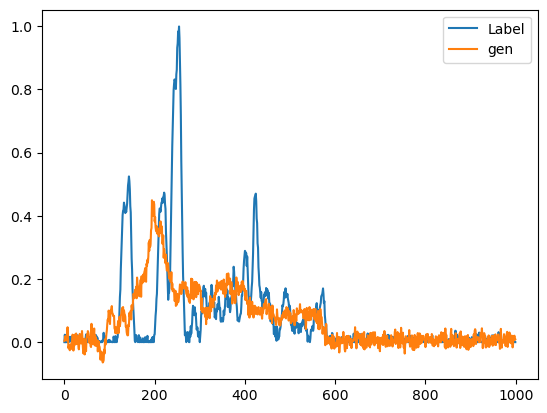

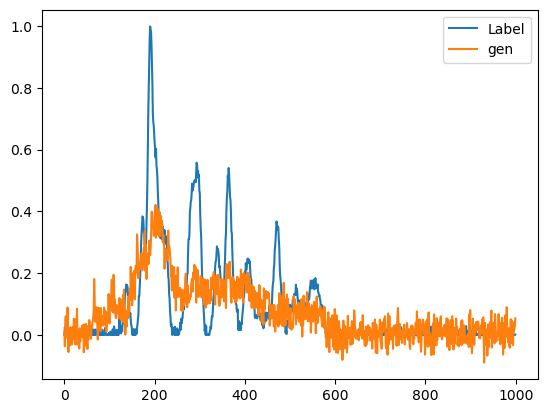

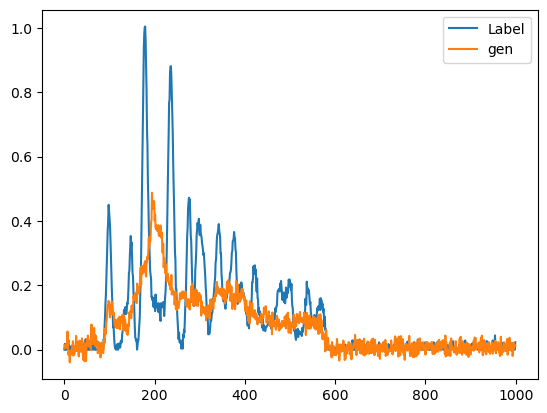

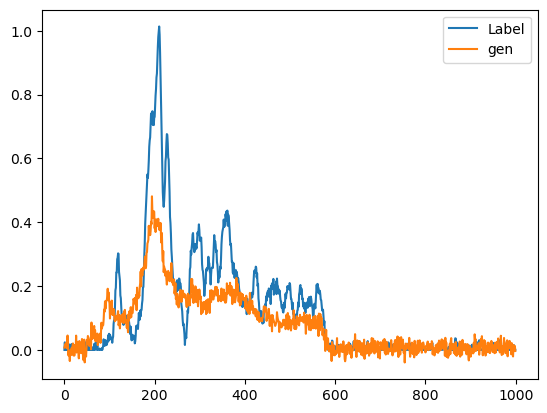

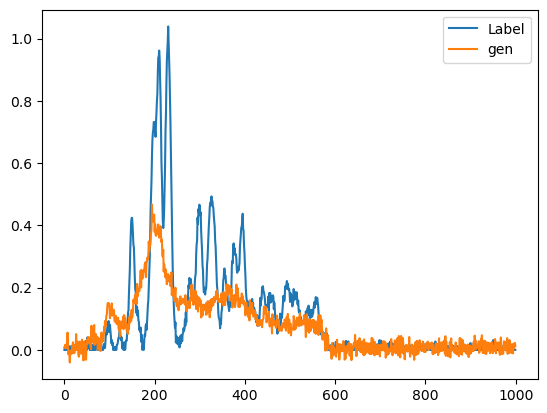

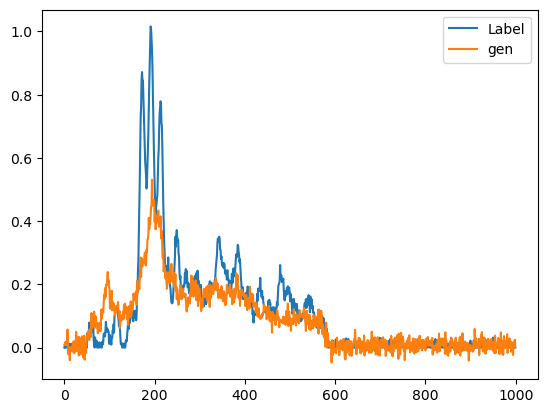

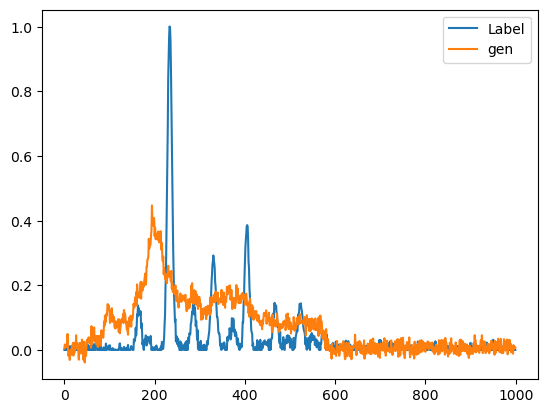

In [87]:
sample(trained_model, val_loader, device='cuda')